<a href="https://colab.research.google.com/github/naguzmans/opportunistic-utm/blob/master/03_Organize_Flight_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create Flights Array

The goal of this code is to create daily arrays of shape (24 hours, 100 px, 100 px, 20 channels) for training the model later.

**Lists folders containing data**

In [ ]:
import glob

# Home folder
import os
os.chdir('/content/drive/MyDrive/opportunistic-utm/')

# List of folders with data
folder_list = []
month = '2018-12' # also /**/ for all months
for folder in glob.iglob(f'dataset/{month}/**/', recursive=False):
  folder_list.append(folder)

folder_list[:5]

['dataset/2018-12/2018-12-01/',
 'dataset/2018-12/2018-12-02/',
 'dataset/2018-12/2018-12-03/',
 'dataset/2018-12/2018-12-04/',
 'dataset/2018-12/2018-12-05/']

**Creates unmasked arrays of (24 hours, 100px, 100px, 20 channels)**

In [ ]:
import gc
import numpy as np
from tqdm import tqdm
import os
%config InlineBackend.figure_format = 'retina'

for folder in tqdm(folder_list):
  files = np.sort(glob.glob(folder + '/*.npy', recursive=False))
  hours_array = np.expand_dims(np.moveaxis(np.load(files[0]), 0, -1), 0)
  hours_array = np.empty((1,100,100,20))

  for i in range(0, 24):
    next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
    hours_array = np.concatenate((hours_array, next_hour), axis=0)

  folder_name = os.path.normpath(folder).split(os.sep)[2]
  filename = folder_name.replace('-','')
  np.save(f'dataset/00_results/daily_unmasked/{filename}.npy', hours_array[1:])

100%|██████████| 31/31 [08:38<00:00, 16.72s/it]


# Visualization

**Multichannel array flattener**

In [ ]:
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

**Preview single hour**

Text(0.5, 1.0, 'Day 2018/02/03 - Hour 13:00')

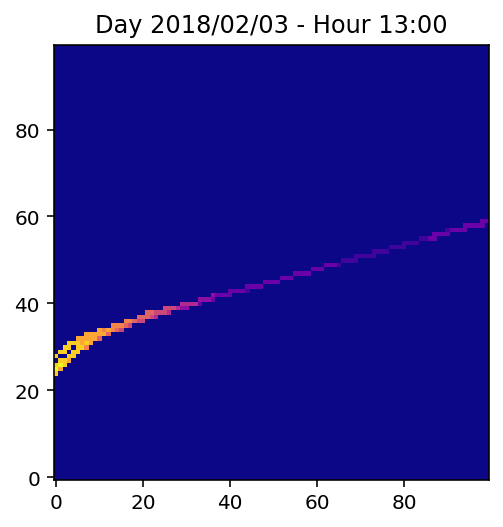

In [ ]:
# Previews single image
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

year = 2018
month = 2
day = 3
hour = 13
day_array = np.load(f'dataset/00_results/daily_unmasked/{year}{str(month).zfill(2)}{str(day).zfill(2)}.npy')
flatten = flatten_array(day_array[hour])
plt.imshow(flatten, origin='lower', cmap = plt.get_cmap('plasma'))
plt.title(f'Day {year}/{str(month).zfill(2)}/{str(day).zfill(2)} - Hour {hour}:00')

**Preview full day**

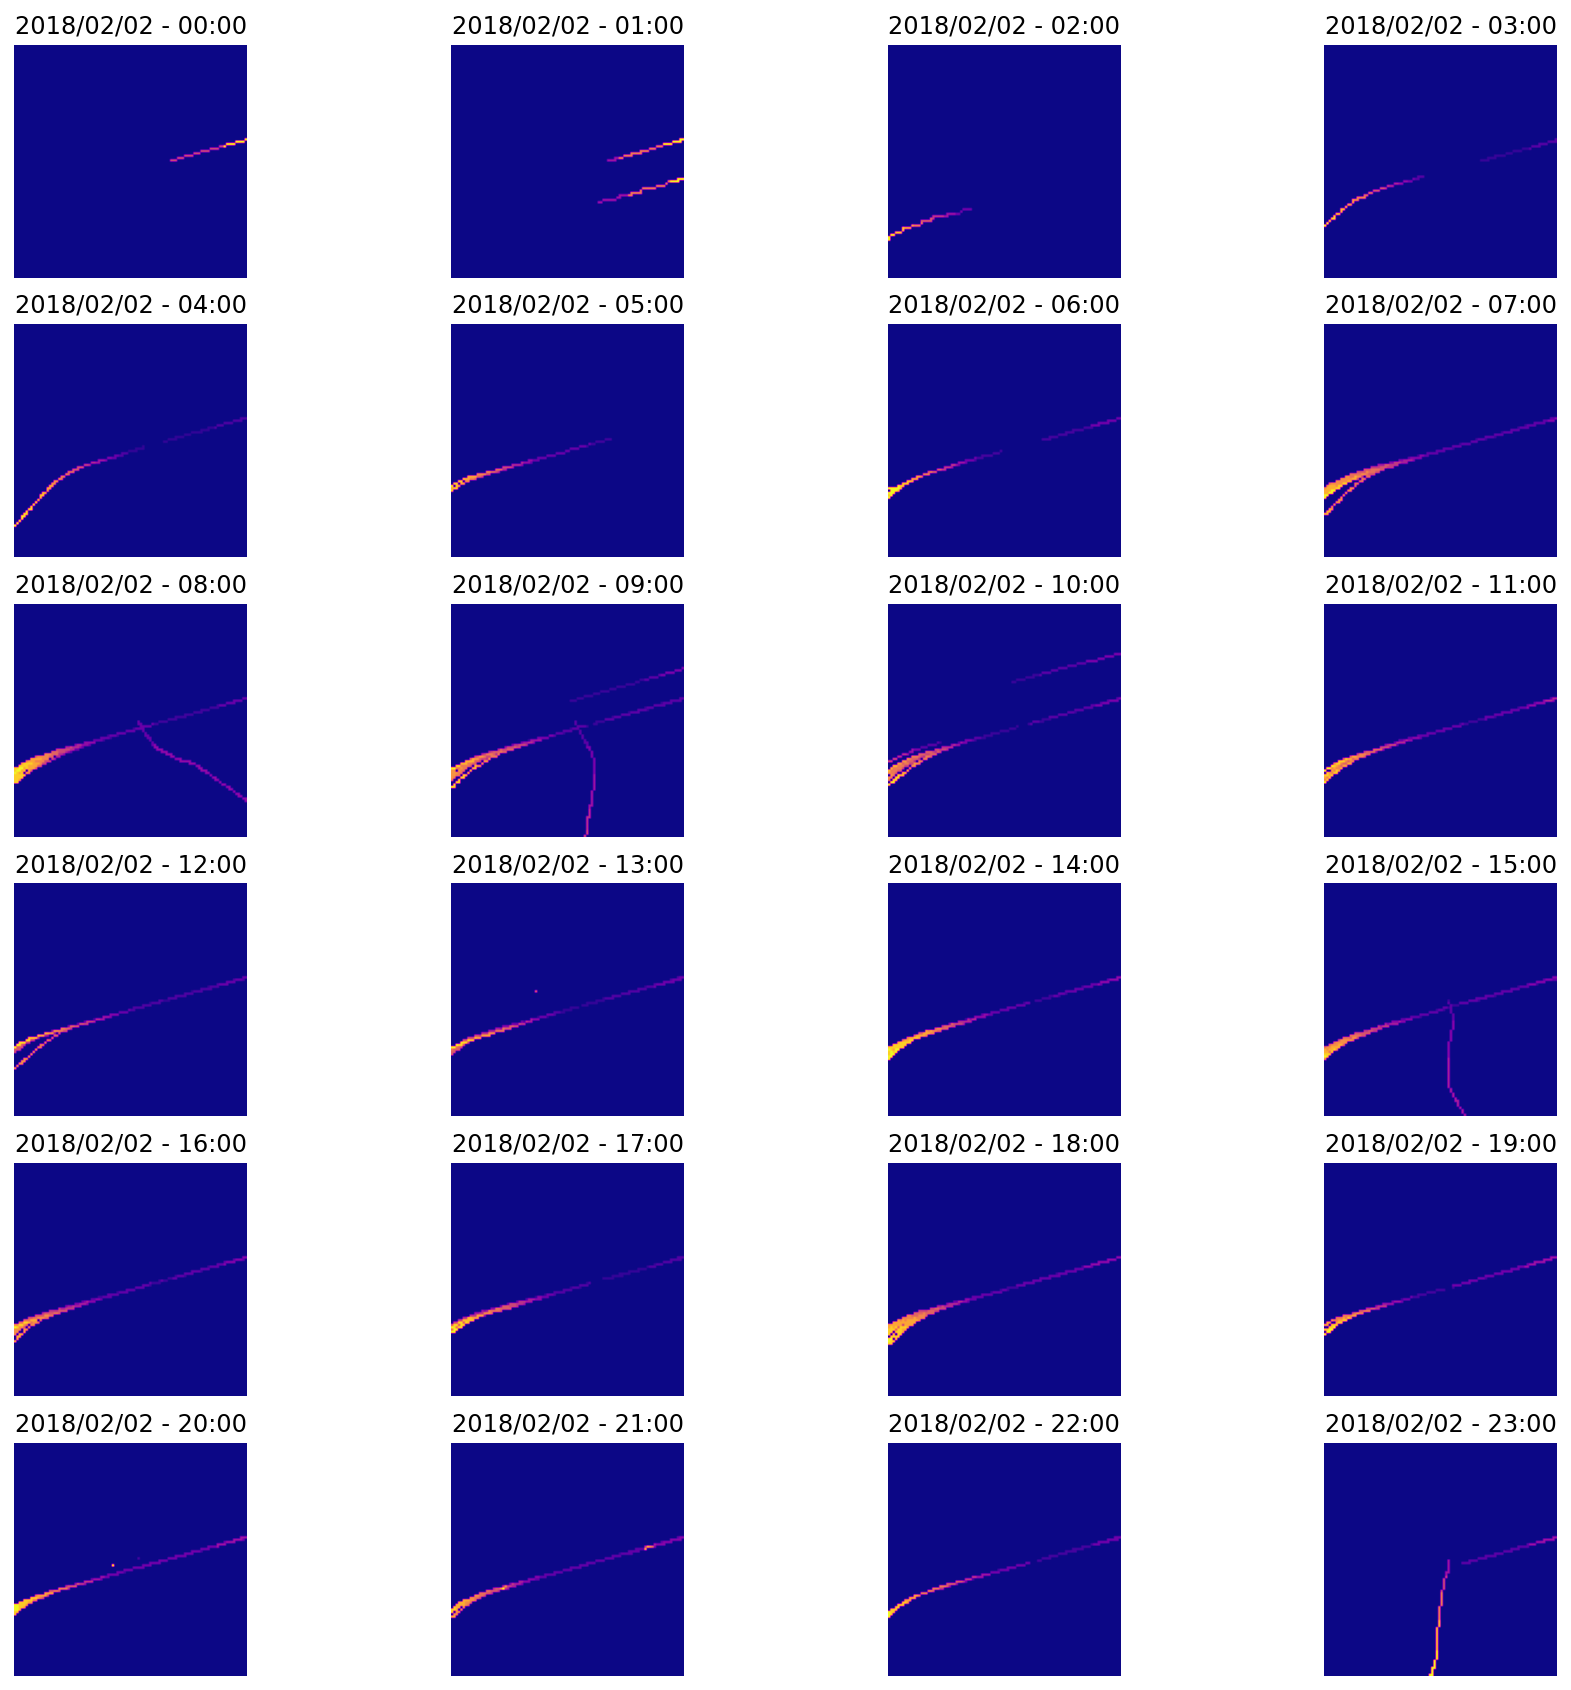

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  plot = ax.imshow(flatten_array(day_array[idx]), origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f'{year}/{str(month).zfill(2)}/{str(day).zfill(2)} - {str(idx).zfill(2)}:00')
  ax.axis("off")

# Calculate Flights Envelope

**Flights average**

In [ ]:
import glob
import numpy as np

# List of files with data
files_list = []
for file in glob.iglob(f'dataset/00_results/daily_unmasked/*.npy', recursive=False):
  files_list.append(file)

files_list = np.sort(files_list).tolist()[365:730]
files_list[0:10]
print(f'Files Length: {len(files_list)}')

Files Length: 365


100%|██████████| 365/365 [03:25<00:00,  1.78it/s]


Max 1: 5630.0
Max 2: 5630.0
-----------
Busy Pixels 
-----------
Level 0: 131
Level 1: 179
Level 2: 166
Level 3: 178
Level 4: 175
Level 5: 196
Level 6: 205
Level 7: 209
Level 8: 209
Level 9: 192
Level 10: 173
Level 11: 136
Level 12: 83
Level 13: 11
Level 14: 0
Level 15: 0
Level 16: 0
Level 17: 0
Level 18: 0
Level 19: 0


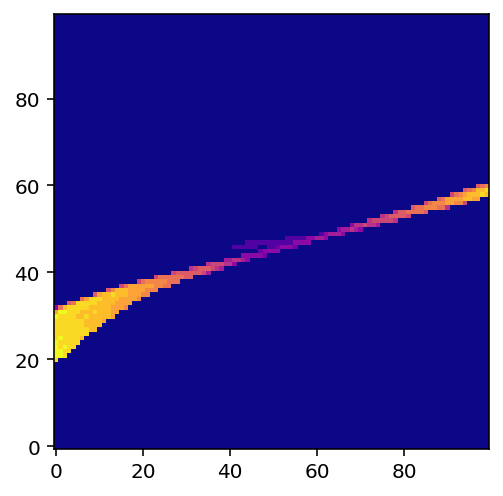

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Flights average
flights_average = np.zeros([100,100,20])
for file in tqdm(files_list):
  day_array = np.sum(np.load(file), axis=0)
  flights_average = np.add(flights_average, day_array)
print(f'Max 1: {np.max(flights_average)}')
# flights_average /= (len(files_list)*24)
# flights_average /= (np.max(flights_average))
print(f'Max 2: {np.max(flights_average)}')

print(f'-----------')
print(f'Busy Pixels ')
print(f'-----------')

flights_average = np.where(flights_average >= 88, 1, 0)

# Show number of pixels by level
for i in range(0, flights_average.shape[-1]):
  print(f'Level {i}: {np.count_nonzero(flights_average[:,:,i] > 0)}')

flights_flatten_average = flatten_array(flights_average)
plt.imshow(flights_flatten_average, origin='lower', cmap = plt.get_cmap('plasma'))
plt.show()

**Save Average Flights Array**

In [ ]:
np.save(f'dataset/00_results/flights_average_2018.npy', flights_average)

# Mask Flights Array to Remove Outliers [Not Included in Thesis]

(24, 100, 100, 20)

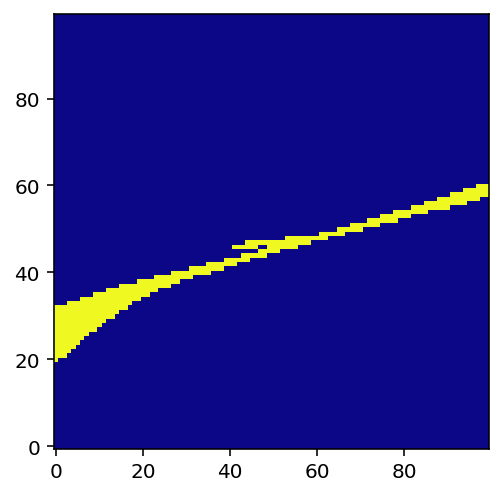

In [ ]:
# Calculates the envelope for all flight levels
flights_envelope = np.where(flights_flatten_average > 0, 1, 0)
stack = []
for i in range(20):
  stack.append(flights_envelope)

flights_envelope = np.array(stack)
flights_envelope = np.moveaxis(flights_envelope, 0, -1)

hour_stack = []
for j in range(24):
  hour_stack.append(flights_envelope)
flights_envelope = np.array(hour_stack)

plt.imshow(flatten_array(flights_envelope[0]), origin='lower', cmap='plasma')
flights_envelope.shape

In [ ]:
np.save(f'dataset/00_results/flights_envelope_2019.npy', flights_envelope)

**Multiply hours by envelope**

In [ ]:
from tqdm import tqdm

for file in tqdm(files_list):
  day_array = np.load(file)
  masked_day_array = day_array * flights_envelope 
  np.save(file.replace('unmasked', 'masked'), masked_day_array)

100%|██████████| 730/730 [12:19<00:00,  1.01s/it]


**Preview full day**

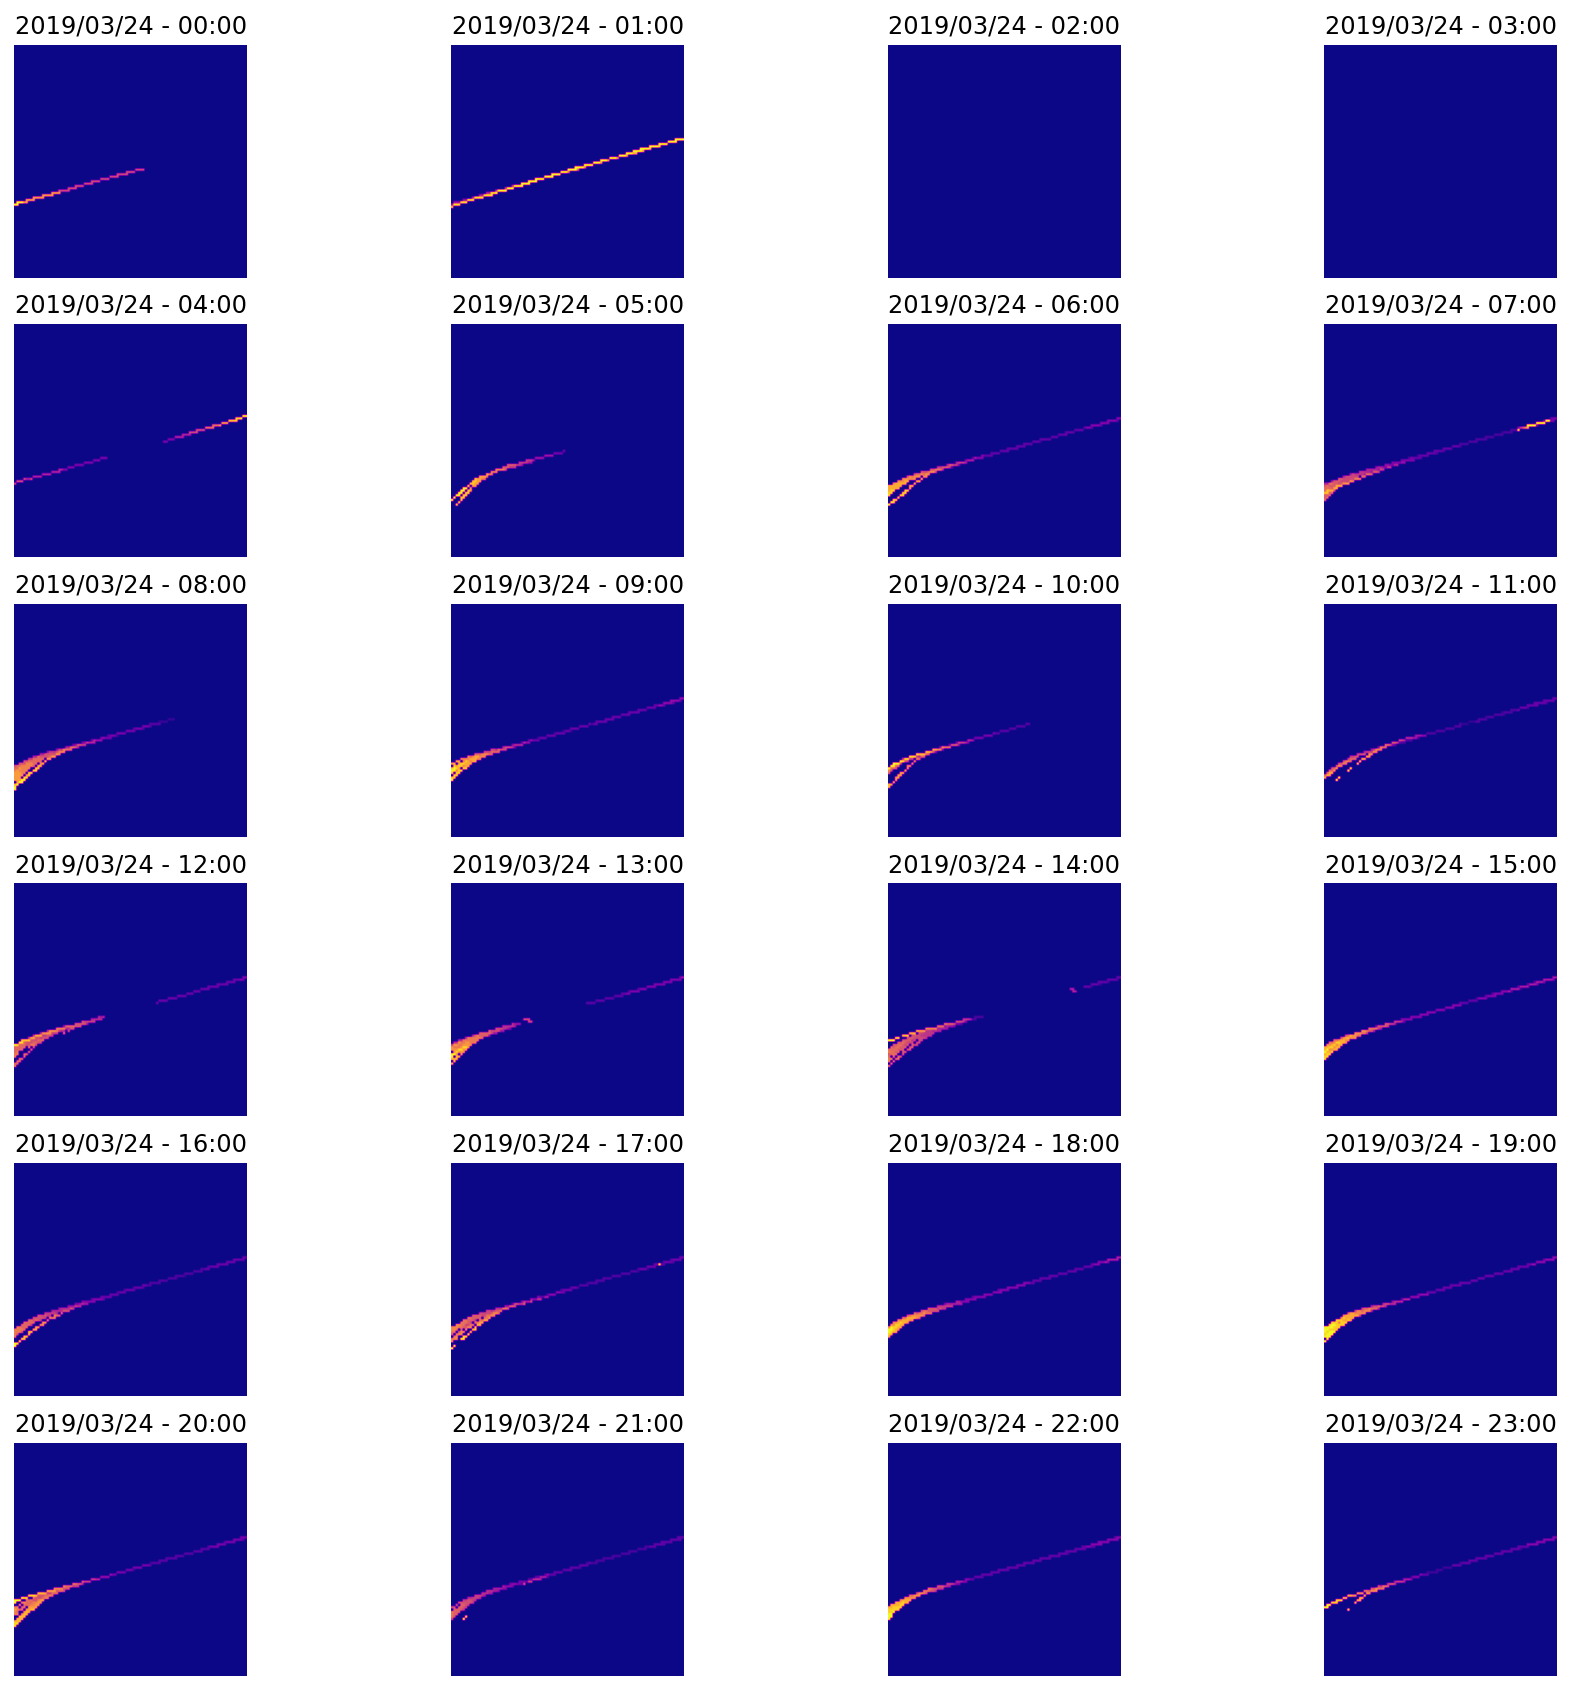

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

day_masked_array = np.load(f'dataset/00_results/daily_masked/{year}{str(month).zfill(2)}{str(day).zfill(2)}.npy')

fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  plot = ax.imshow(flatten_array(day_masked_array[idx]), origin='lower', cmap = plt.get_cmap('plasma'))
  ax.set_title(f'{year}/{str(month).zfill(2)}/{str(day).zfill(2)} - {str(idx).zfill(2)}:00')
  ax.axis("off")